<a href="https://colab.research.google.com/github/yblee110/smol-course-modulabs/blob/main/study/yblee110/2_preference_alignment/notebooks/orpo_finetuning_example_yblee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Difficulty Levels

🐢 Use the `trl-lib/ultrafeedback_binarized` dataset

🐕 Try out the `argilla/ultrafeedback-binarized-preferences` dataset

🦁 Try on a subset of mlabonne's `orpo-dpo-mix-40k` dataset

In [1]:
!pip install transformers datasets trl huggingface_hub bitsandbytes

import torch
import os
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
)
from trl import ORPOConfig, ORPOTrainer, setup_chat_format

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.9/313.9 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Authenticate to Hugging Face
from huggingface_hub import login

login()

In [3]:
dataset = load_dataset(path="trl-lib/ultrafeedback_binarized")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/643 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/131M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/62135 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
# TODO: 🐕 If your dataset is not represented as conversation lists, you can use the `process_dataset` function to convert it.

In [5]:
model_name = "HuggingFaceTB/SmolLM2-135M"

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Model to fine-tune
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name,
    torch_dtype=torch.float32,
).to(device)
model.config.use_cache = False
tokenizer = AutoTokenizer.from_pretrained(model_name)
model, tokenizer = setup_chat_format(model, tokenizer)

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolLM2-FT-ORPO"
finetune_tags = ["smol-course", "module_1"]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

In [6]:
orpo_args = ORPOConfig(
    # Small learning rate to prevent catastrophic forgetting
    learning_rate=8e-6,
    # Linear learning rate decay over training
    lr_scheduler_type="linear",
    # Maximum combined length of prompt + completion
    max_length=1024,
    # Maximum length for input prompts
    max_prompt_length=512,
    # Controls weight of the odds ratio loss (λ in paper)
    beta=0.1,
    # Batch size for training
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    # Helps with training stability by accumulating gradients before updating
    gradient_accumulation_steps=4,
    # Memory-efficient optimizer for CUDA, falls back to adamw_torch for CPU/MPS
    optim="paged_adamw_8bit" if device == "cuda" else "adamw_torch",
    # Number of training epochs
    num_train_epochs=1,
    # When to run evaluation
    evaluation_strategy="steps",
    # Evaluate every 20% of training
    eval_steps=0.2,
    # Log metrics every step
    logging_steps=1,
    # Gradual learning rate warmup
    warmup_steps=10,
    # Disable external logging
    report_to="none",
    # Where to save model/checkpoints
    output_dir="./results/",
    # Enable MPS (Metal Performance Shaders) if available
    use_mps_device=device == "mps",
    hub_model_id=finetune_name,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [7]:
trainer = ORPOTrainer(
    model=model,
    args=orpo_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    processing_class=tokenizer,
)

/usr/local/lib/python3.11/dist-packages/trl/trainer/orpo_trainer.py:278: UserWarning: When using DPODataCollatorWithPadding, you should set `remove_unused_columns=False` in your TrainingArguments we have set it for you, but you should do it yourself in the future.
  warnings.warn(


Map:   0%|          | 0/62135 [00:00<?, ? examples/s]

Map:   0%|          | 0/62135 [00:00<?, ? examples/s]

Map:   0%|          | 0/62135 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [8]:
trainer.train()  # Train the model

# Save the model
trainer.save_model(f"./{finetune_name}")

Step,Training Loss,Validation Loss,Runtime,Samples Per Second,Steps Per Second,Rewards/chosen,Rewards/rejected,Rewards/accuracies,Rewards/margins,Logps/rejected,Logps/chosen,Logits/rejected,Logits/chosen,Nll Loss,Log Odds Ratio,Log Odds Chosen
1554,6.804600,1.913981,35.630800,28.066000,14.033000,-0.152351,-0.165385,0.523000,0.013034,-1.653851,-1.523515,8.156769,7.493722,1.840493,-0.734881,0.156954
3108,6.754400,1.882170,35.684700,28.023000,14.012000,-0.149452,-0.162055,0.521000,0.012603,-1.620548,-1.494516,7.493726,6.929614,1.808378,-0.737921,0.153856
4662,7.725500,1.865883,35.666800,28.037000,14.019000,-0.148077,-0.159809,0.525000,0.011733,-1.598091,-1.480766,7.353496,6.803668,1.792157,-0.737257,0.144997
6216,7.158600,1.857670,35.656600,28.045000,14.023000,-0.147424,-0.159018,0.528000,0.011594,-1.590178,-1.474236,7.237121,6.709979,1.783947,-0.737231,0.144303


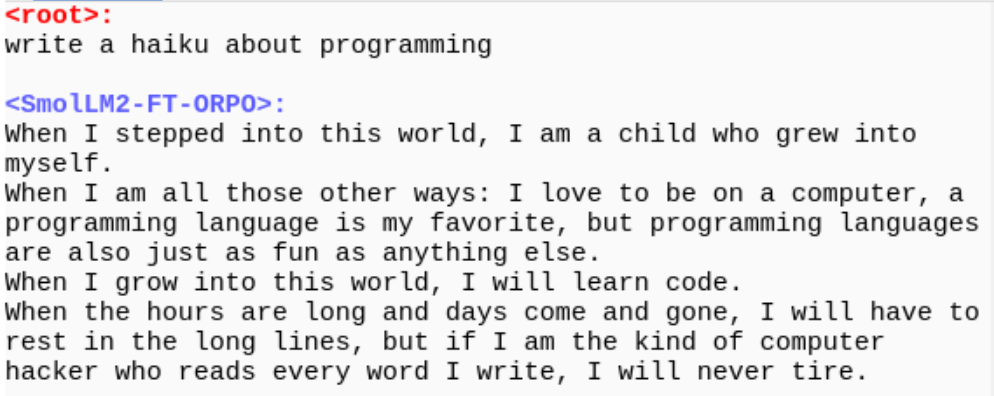